#LAB 10

### Question 1

Accuracy: 0.93
Precision: 0.73
Recall: 0.63
F1 Score: 0.68


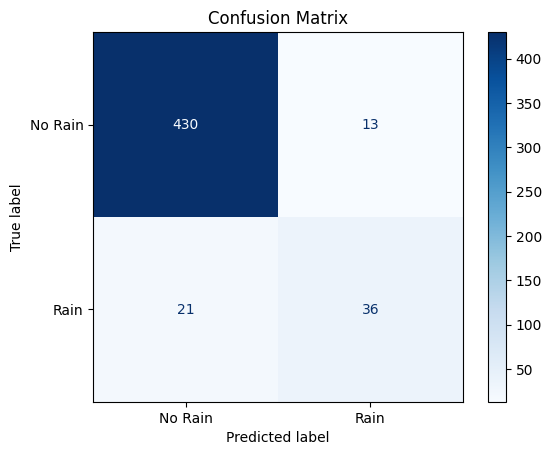

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Step 1: Load Dataset
df = pd.read_csv('/content/weather_forecast_data.csv')  # Replace with your actual file name

# Step 2: Handle Missing Values
df.dropna(inplace=True)
df['Rain'] = df['Rain'].map({'no rain': 0, 'rain': 1})
# Step 3: Define Features and Target
features = ['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']
target = 'Rain'

X = df[features]
y = df[target]

# Step 4: Normalize the Feature Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 6: Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 7: Make Predictions
y_pred = model.predict(X_test)

# Step 8: Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Step 9: Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    display_labels=['No Rain', 'Rain'],
    cmap='Blues'
)
plt.title("Confusion Matrix")
plt.show()


### Question 2

(1500, 3)
[[-0.26123728  0.60934999 -0.74863053]
 [-0.46885478  0.75136024  0.46436299]
 [ 0.60420539  0.36268819 -0.70950203]
 ...
 [-0.5964038  -0.14731513 -0.78905054]
 [ 0.90971566  0.38708361 -0.15027875]
 [-0.62572733 -0.7393528  -0.24864179]]


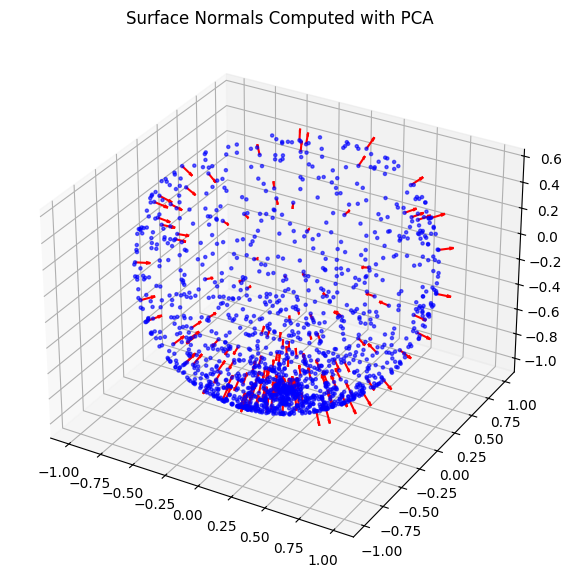

In [66]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Load or Generate Point Cloud (Example: Random surface)
def generate_point_cloud(n_points=500):
  num_points = 1500
  phi = np.random.uniform(1, 4, num_points)
  theta = np.random.uniform(1, 5 * np.pi, num_points)
  x = np.sin(phi) * np.cos(theta)
  y = np.sin(phi) * np.sin(theta)
  z = np.cos(phi)
  points = np.stack([x, y, z], axis=1)
  return points
points = generate_point_cloud()
print(points.shape)
print(points)
# Step 2: Find k nearest neighbors for aeach point
k = 10  # Number of neighbors
nbrs = NearestNeighbors(n_neighbors=k + 1).fit(points)
distances, indices = nbrs.kneighbors(points)

# Step 3: Compute PCA and normals
normals = np.zeros_like(points)

for i, idx in enumerate(indices):
    neighbors = points[idx[1:]]  # skip the first point (it's the point itself)
    cov = np.cov(neighbors - neighbors.mean(axis=0), rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov)
    normal = eigvecs[:, 0]  # Smallest eigenvalue
    normals[i] = normal

# Step 4: Visualize
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5, color='blue', alpha=0.6)

# Plot normals (every Nth to reduce clutter)
N = 10
ax.quiver(points[::N, 0], points[::N, 1], points[::N, 2],
          normals[::N, 0], normals[::N, 1], normals[::N, 2],
          length=0.1, color='red')

ax.set_title("Surface Normals Computed with PCA")
plt.show()


### Question 3

In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Generate blank image
def create_blank_image():
    return np.zeros((200, 200), dtype=np.uint8)

# Draw shapes
def draw_circle():
    img = create_blank_image()
    cv2.circle(img, (100, 100), 50, 255, -1)
    return img

def draw_ellipse():
    img = create_blank_image()
    cv2.ellipse(img, (100, 100), (60, 30), 0, 0, 360, 255, -1)
    return img

def draw_rectangle():
    img = create_blank_image()
    cv2.rectangle(img, (50, 75), (150, 125), 255, -1)
    return img

def draw_square():
    img = create_blank_image()
    cv2.rectangle(img, (50, 50), (150, 150), 255, -1)
    return img

def draw_star():
    img = create_blank_image()
    points = np.array([[100, 40], [120, 90], [170, 90], [130, 120],
                       [150, 170], [100, 140], [50, 170], [70, 120],
                       [30, 90], [80, 90]], np.int32)
    cv2.fillPoly(img, [points], 255)
    return img

# Extract features (Hu Moments + area + perimeter)
def extract_features(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return np.zeros(10)
    cnt = contours[0]
    hu_moments = cv2.HuMoments(cv2.moments(cnt)).flatten()
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    return np.concatenate([hu_moments, [area, perimeter]])

# Generate dataset
shape_funcs = {
    "circle": draw_circle,
    "ellipse": draw_ellipse,
    "rectangle": draw_rectangle,
    "square": draw_square,
    "star": draw_star
}

features = []
labels = []

for label, func in shape_funcs.items():
    for _ in range(50):  # 50 samples per shape
        img = func()
        feat = extract_features(img)
        features.append(feat)
        labels.append(label)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2 , random_state= 43)

# Train SVM
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

      circle       1.00      1.00      1.00         9
     ellipse       0.48      1.00      0.65        10
   rectangle       0.00      0.00      0.00        11
      square       1.00      1.00      1.00         9
        star       1.00      1.00      1.00        11

    accuracy                           0.78        50
   macro avg       0.70      0.80      0.73        50
weighted avg       0.68      0.78      0.71        50



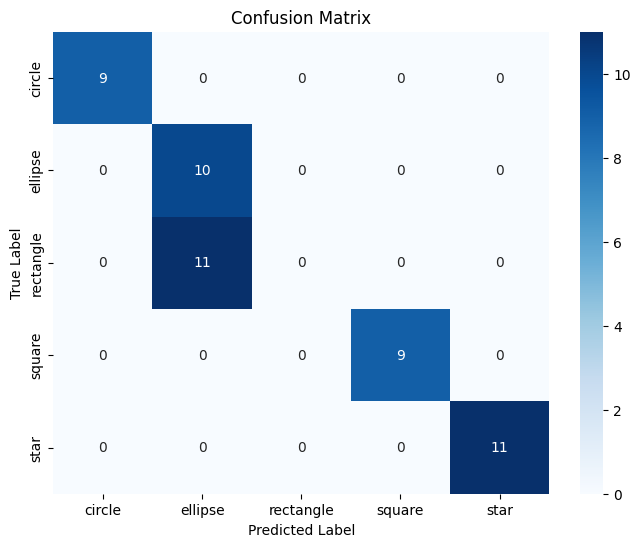

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Generate confusion matrix
labels_unique = list(shape_funcs.keys())
cm = confusion_matrix(y_test, y_pred, labels=labels_unique)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_unique,
            yticklabels=labels_unique)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()